In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os, shutil
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

#from sklearn.model_selection import train_test_split
from pathlib import Path
from torch import nn
from torch.utils.data.dataset import Dataset
from torchvision import models, transforms
from collections import defaultdict
from random import shuffle
from PIL import Image
from shapely.geometry import Polygon

import functools


%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [9]:
torch.cuda.device_count()

2

In [3]:
class_data = pd.read_csv('pklot_class_data.csv')
bbox_data = pd.read_csv('pklot_bbox_data.csv')

In [4]:
data = class_data.merge(bbox_data, left_on='image_path', right_on='image_path')

In [5]:
data.head()

,image_path,occupied,rotated_bbox
0,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 ...,651 636 141 83 -34 705 563 139 77 -44 732 480 ...
1,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 ...,651 636 141 83 -34 705 563 139 77 -44 732 480 ...
2,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 ...,651 636 141 83 -34 705 563 139 77 -44 732 480 ...
3,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 ...,651 636 141 83 -34 705 563 139 77 -44 732 480 ...
4,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 ...,651 636 141 83 -34 705 563 139 77 -44 732 480 ...


In [6]:
data = pd.read_csv('pklot_combined_bbox_rbox.csv')

In [7]:
data['rotated_bbox'] = data['rotated_bbox'].map(lambda x: np.array([int(num) for num in x.split()]))
data['rotated_bbox'] = data['rotated_bbox'].map(lambda x: np.split(x, len(x) / 5))

In [8]:
data['occupied'] = data['occupied'].map(lambda x: [int(num) for num in x.split()])

In [9]:
data['image_path'] = data['image_path'].map(lambda x: Path(x))

In [10]:
data.head()

,image_path,occupied,rotated_bbox
0,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[651, 636, 141, 83, -34], [705, 563, 139, 77,..."
1,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[651, 636, 141, 83, -34], [705, 563, 139, 77,..."
2,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[651, 636, 141, 83, -34], [705, 563, 139, 77,..."
3,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[651, 636, 141, 83, -34], [705, 563, 139, 77,..."
4,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[651, 636, 141, 83, -34], [705, 563, 139, 77,..."


In [11]:
occupied, image_path, rotated_bbox = (data.loc[0, 'occupied'], data.loc[0, 'image_path'], data.loc[0, 'rotated_bbox'])

In [12]:
image_path

PosixPath('PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18_18_35_15.jpg')

In [13]:
occupied

[0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [14]:
rotated_bbox

[array([651, 636, 141,  83, -34]),
 array([705, 563, 139,  77, -44]),
 array([732, 480, 124,  60, -48]),
 array([762, 409, 113,  54, -51]),
 array([773, 346, 109,  49, -56]),
 array([803, 296, 101,  47, -61]),
 array([818, 255,  95,  33, -65]),
 array([837, 222,  91,  34, -68]),
 array([856, 192,  86,  31, -69]),
 array([469, 649,  82, 169, -16]),
 array([644, 352,  45, 116, -17]),
 array([687, 300,  42, 101, -14]),
 array([693, 262,  38, 108, -10]),
 array([733, 227,  35,  97,  -8]),
 array([737, 193,  29,  93,  -9]),
 array([307, 326,  73,  64, -27]),
 array([361, 283,  60,  56, -32]),
 array([403, 246,  68,  48, -43]),
 array([452, 214,  61,  48, -47]),
 array([482, 184,  61,  47, -45]),
 array([513, 161,  54,  36, -48]),
 array([127, 363,  79,  76, -19]),
 array([198, 310,  79,  75, -19]),
 array([260, 276,  73,  63, -25]),
 array([316, 243,  67,  56, -30]),
 array([359, 211,  58,  50, -30]),
 array([401, 186,  55,  47, -36]),
 array([437, 162,  54,  49, -34])]

In [15]:

def transform_get_image_from_path(image_path, occupied, rotated_bbox):
    return Image.open(image_path, mode='r'), occupied, rotated_bbox


def transform_get_pil(image, occupied, rotated_bbox):
    return TF.to_pil_image(image), occupied, rotated_bbox


def transform_get_tensor(image, occupied, rotated_bbox):
    return TF.to_tensor(image), occupied, rotated_bbox


def transform_padding(img, occupied, rotated_bbox):
    """
    Paramters:
    ----------
    img: tensor (CxHxW)
    occupied: tensor occupied or not 
    rotated_bbox: tesnor (N, 5) of rotated boxes 
    
    Returns:
    image: the image loaded padded with zeros on the short size
    --------
    """
    
    length = np.max(img.size())
    img_size =  3, length, length
    
    pad_bot = length - img.size()[1]
    pad_right = length - img.size()[2]
    
    new_image = F.pad(img, (0, pad_right, 0, pad_bot))
    
    return new_image, occupied, rotated_bbox
    

def transform_random_crop(image, occupied, rotated_bbox):
    """
    Parameters:
    image: a tensor image
    occupied: occupied tensor (N,)
    rotated_bbox: tensor (N, 5) of rotated bounding boxes

    Returns:
    image: cropped image
    new_occp: occupied tensor (M,) depending on how many of the 
        rotated boxes are within the image
    rotated_bbox: tesnor (M, 5) rotated bboxes updated according to crop
    """
    
    _, height, width = image.shape
    m = int(np.min([height, width]))
    
    
    
    counter = 0

    while counter < 50:
        counter += 1
        
        rnd_size = np.random.randint(300, m + 1)


        rnd_x = np.random.randint(0, height - 299)
        rnd_y = np.random.randint(0, width - 299)

        x1 = rnd_x
        x2 = rnd_x + rnd_size

        y1 = rnd_y
        y2 = rnd_y + rnd_size
        
        new_image = image[:, x1:x2, y1:y2] # TF.crop(image, rnd_y, rnd_x, rnd_size, rnd_size)

        new_rbbox = rotated_bbox.clone().detach()

        to_remain = (new_rbbox[:, 0] < y2) * (new_rbbox[:, 0] > y1) * (new_rbbox[:, 1] > x1) * (new_rbbox[:, 1] < x2)

        if not to_remain.any():
            continue

        
        new_rbbox = new_rbbox[to_remain, :]
        new_occp = occupied[to_remain]

        new_rbbox[:, 0] = new_rbbox[:, 0] - y1
        new_rbbox[:, 1] = new_rbbox[:, 1] - x1


        return new_image, new_occp, new_rbbox


    #         for i, (cx, cy, h, w, a) in enumerate(rotated_bbox):
    #             if x1 < cx and cx < x2 and y1 < cy and cy < y2:
    #                 new_occp.append(occupied[i])
    #                 new_rbbox.append([cx - x1, cy - y1, h, w, a])




    
    return image, occupied, rotated_bbox

    

def transform_resize(image, occupied, rotated_bbox):
    """
    Parameters:
    -----------
    image: Tensor Image, make sure it is square
    
    Return:
    -------
    image: Tensor image
    """
    
    _, width, height = image.shape
    ratio = width / 300
    image = image.unsqueeze(dim=0)
    image = F.interpolate(image, size=(300,300), mode='bilinear')
    image = image.squeeze(dim=0)
#     image = TF.resize(image, (300, 300))
    rotated_bbox[:, 0:4] /= ratio
    
#     rotated_bbox = list(map(lambda rbox: [int(rbox[0]/ratio), int(rbox[1]/ratio),
#                                           int(rbox[2]/ratio), int(rbox[3]/ratio), rbox[4]], rotated_bbox))
    
    
    
    return image, occupied, rotated_bbox

def transform_normalize_color(image, occupied, rotated_bbox):
    """
    Normalizes color images.
    Assumes Tensor image as input.
    Returns:
    --------
    image: tensor
    """
    
    image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    
    return image, occupied, rotated_bbox
    
    
    
def transform_guassian_noise(image, occupied, rotated_bbox):
    """
    Assumes image is tensor.
    Adds guassian noise to the image:
    assume image is tensor
    """
    
    noise = torch.randn_like(image) / 12
    image = image + noise
    image = torch.clamp(image, 0, 1)
    
    
    return image, occupied, rotated_bbox
    
    

def transform_random_mirror(image, occupied, rotated_bbox):
    """
    Assumes image is PIL.
    So make sure to have a PIL transformation before this one!
    Randomly mirrors the image horizontally or vertially
    Call only after resize
    """
    
    
    vflip = bool(np.random.randint(0, 2))
    hflip = bool(np.random.randint(0, 2))
    length, width = image.size
    
    if vflip:
        image = TF.vflip(image)
        rotated_bbox[:, 1] = length - rotated_bbox[:, 1]
        rotated_bbox = torch.index_select(rotated_bbox, 1, torch.LongTensor([0,1,3,2,4]))
#         tmp = rotated_bbox[:, 2].clone().detach()
#         rotated_bbox[:, 2] = rotated_bbox[:, 3]
#         rotated_bbox[:, 3] = tmp
        rotated_bbox[:, 4] = -90 - rotated_bbox[:, 4]
#         rotated_bbox = list(map(lambda rbox: [rbox[0], 300 - rbox[1], rbox[2], rbox[3], -rbox[4]], rotated_bbox))
        
    if hflip:
        image = TF.hflip(image)
        rotated_bbox[:, 0] = width - rotated_bbox[:, 0]
        rotated_bbox = torch.index_select(rotated_bbox, 1, torch.LongTensor([0,1,3,2,4]))
#         tmp = rotated_bbox[:, 2].clone().detach()
#         rotated_bbox[:, 2] = rotated_bbox[:, 3]
#         rotated_bbox[:, 3] = tmp
        rotated_bbox[:, 4] = -90 - rotated_bbox[:, 4]
#         rotated_bbox = list(map(lambda rbox: [300 - rbox[0], rbox[1], rbox[2], rbox[3], -rbox[4]], rotated_bbox))
    
    
    return image, occupied, rotated_bbox
    

def transform_random_rotate(image, occupied, rotated_bbox):
    """
    TODO
    Parameters:
    -----------
    image: make sure it is square and is PIL,
    So make sure to have a PIL transformation before this one!
    
    Return:
    -------
    image: tensor
    """
    angles = [0, 90, 180, 270]
    
    angle_idx = np.random.randint(0, 4)
    
    image = TF.rotate(image, angles[angle_idx])
    
    pass
    



In [16]:
def show_img(image, figsize=None, ax=None):
    if not ax: 
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(np.transpose(image, (1, 2, 0)), zorder=1)
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def to_corner(cx, cy, w, h, a, up, right):
    theta = a.double() * np.pi / 180 
    # cx, cy - center of square coordinates
    # x, y - coordinates of a corner point of the square
    # theta is the angle of rotation
    if up:
        y = cy + (h / 2)
    else:
        y = cy - (h / 2)

    if right:
        x = cx + (w / 2)
    else:
        x = cx - (w / 2)

    # translate point to origin
    temp_x = x - cx
    temp_y = y - cy

    # now apply rotation
    rotated_x = temp_x * np.cos(theta) - temp_y * np.sin(theta)
    rotated_y = temp_x * np.sin(theta) + temp_y * np.cos(theta)

    # translate back
    x_prime = rotated_x + cx
    y_prime = rotated_y + cy
    
    return x_prime, y_prime

def create_polygon(cx, cy, w, h, a):
    return Polygon([to_corner(cx, cy, w, h, a, up, right) for up, right in 
                    [(True, False), (True, True), (False, True), (False, False)]])

def create_polygon_list(rotated_bboxes):
    return [create_polygon(box[0], box[1], box[3], box[2], box[4]) for box in rotated_bboxes]

def draw_poly(ax, poly, c='black', linewidth=2):
    x,y = poly.exterior.xy
    ax.plot(x, y, color=c, alpha=0.7, linewidth=linewidth, solid_capstyle='round', zorder=2)

def show_truth(image, rotated_bboxes, labels, ax, linewidth=1):
    polygons = create_polygon_list(rotated_bboxes)
    labels = [int(num) for num in labels.tolist()]
    show_img(image, ax=ax)
    
    legend_elements = [Patch(edgecolor='g', label='Occupied', fill=False), 
                       Patch(edgecolor='r', label='Empty', fill=False)]
    ax.legend(handles=legend_elements, loc='upper right')
    
    color_map = {0: 'r', 1: 'g'}

    for i, poly in enumerate(polygons):
        draw_poly(ax, poly, c=color_map[labels[i]], linewidth=linewidth)

In [17]:
transforms = [transform_get_image_from_path,
              transform_get_tensor,
              transform_random_crop,
              transform_padding,
              transform_resize,
              transform_get_pil,
              transform_random_mirror,
              transform_get_tensor,
              transform_guassian_noise
             ]

46.7 ms ± 829 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
torch.Size([3, 300, 300])


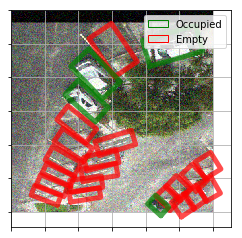

In [19]:
x, y, z = image_path, torch.Tensor(occupied), torch.Tensor(rotated_bbox)

def test_speed(x, y, z, transforms):
    for func in transforms:
        x, y, z = func(x, y, z)
    return x, y, z
    
%timeit test_speed(x, y, z, transforms)

x, y, z = test_speed(x, y, z, transforms)

fig, ax = plt.subplots(1,1)
print(x.size())
show_truth(x, z, y, ax, 5)


In [20]:
transforms_noload = [transform_get_tensor,
                     transform_random_crop,
                     transform_padding,
                     transform_get_pil,
                     transform_resize,
                     transform_random_mirror,
                     transform_get_tensor,
                     transform_guassian_noise
                    ]

In [21]:
x, y, z = image_path, torch.Tensor(occupied), torch.Tensor(rotated_bbox)
%timeit transform_get_image_from_path(x, y, z)
x, y, z = transform_get_image_from_path(x, y, z)

98.8 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
%timeit transform_get_tensor(x, y, z)
x, y, z = transform_get_tensor(x, y, z)

17.9 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit transform_random_crop(x, y, z)
x, y, z = transform_random_crop(x, y, z)

149 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
%timeit transform_padding(x, y, z)
x, y, z = transform_padding(x, y, z)

1.18 ms ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
%timeit transform_resize(x, y, z)
x, y, z = transform_resize(x, y, z)

1.53 ms ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
%timeit transform_get_pil(x, y, z)
x, y, z = transform_get_pil(x, y, z)

3.21 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%timeit transform_random_mirror(x, y, z)
x, y, z = transform_random_mirror(x, y, z)

127 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [28]:
%timeit transform_get_tensor(x, y, z)
x, y, z = transform_get_tensor(x, y, z)

1.13 ms ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
%timeit transform_guassian_noise(x, y, z)
x, y, z = transform_guassian_noise(x, y, z)

2.93 ms ± 77.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
def test_speed(x, y, z, transforms_noload):
    for func in transforms_noload:
        x, y, z = func(x, y, z)
    return x, y, z

34.9 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
torch.Size([3, 300, 300])


TypeError: 'float' object is not iterable

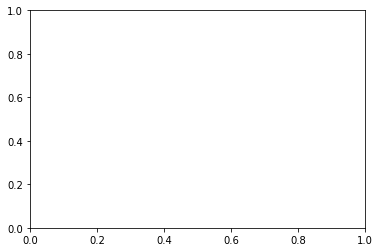

In [26]:

%timeit test_speed(x, y, z, transforms_noload)

x, y, z = test_speed(x, y, z, transforms_noload)

fig, ax = plt.subplots(1,1)
print(x.size())
show_truth(x, z, y, ax, 5)

In [142]:
a = torch.tensor([[1,2,3], [1,2,3], [4,5,6]])

In [143]:
a

tensor([[1, 2, 3],
        [1, 2, 3],
        [4, 5, 6]])

In [146]:
F.pad(a, (0, 2, 0, 3))

tensor([[1, 2, 3, 0, 0],
        [1, 2, 3, 0, 0],
        [4, 5, 6, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]])